In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.sparse.linalg import expm_multiply, expm
from scipy.sparse import diags
from utils import *
from ionq_circuit_utils import *

from os import getenv
from os.path import join
import json
import hashlib

import networkx as nx
from random import shuffle, seed

import requests

from braket.circuits import Circuit
from braket.devices import LocalSimulator
from braket.aws import AwsDevice, AwsQuantumTask

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import TranspilerError
from qiskit.dagcircuit import DAGCircuit
from qiskit.circuit import EquivalenceLibrary, Parameter
from qiskit.circuit.library import RXXGate, RYYGate
from resource_estimate_utils import get_gate_counts
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
IONQ_API_KEY = getenv('IONQ_API_KEY')

# Helper functions

In [3]:
# Sends job and returns job_id
def send_job(job):
    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}",
        "Content-Type": "application/json"
    }
    req = requests.post("https://api.ionq.co/v0.3/jobs", json=job, headers=headers)
    job_id = json.loads(req.content)['id']
    return job_id

In [4]:
def get_ionq_single_job_result(job_id, codewords, use_error_mitigation=False):
    # Get job
    print("Getting job:", job_id)

    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}"
    }

    req = requests.get(f"https://api.ionq.co/v0.3/jobs/{job_id}", headers=headers)
    

    status = json.loads(req.content)['status']
    print(f"Job status: {status}")
    if status == "completed":
        
        headers = {
            "Authorization": f"apiKey {IONQ_API_KEY}"
        }
        if use_error_mitigation:
            params = {"sharpen": "true"} # plural voting aggregation
        else:
            params = {"sharpen": "false"}
        req = requests.get(f"https://api.ionq.co/v0.3/jobs/{job_id}/results", headers=headers, params=params)
        results = json.loads(req.content)
        if "error" in results.keys():
            raise AttributeError(results["message"])
        else:
            freq = np.zeros(len(codewords))
            for i in range(len(codewords)):
                if str(codewords[i]) in results.keys():
                    freq[i] = results[str(codewords[i])]
            return freq
    else:
        raise FileNotFoundError("Job not completed")
    
def get_results(job_ids_path, num_time_points, codewords, use_error_mitigation=False):
    with open(job_ids_path, "r") as f:
        job_ids = json.load(f)
        f.close()

    freq = np.zeros((num_time_points, len(codewords)))
    for i, job_id in enumerate(job_ids):

        freq[i] = get_ionq_single_job_result(job_id, codewords, use_error_mitigation)

    return freq

def cancel_job(job_id):
    print("Cancelling job:", job_id)

    headers = {
        "Authorization": f"apiKey {IONQ_API_KEY}"
    }
    r = requests.put(f"https://api.ionq.co/v0.3/jobs/{job_id}/status/cancel", headers=headers)
    return r

Quantum walk circuit

In [5]:
def get_qw_circuit(graph, t, r):

    # Returns Trotterized circuit for quantum walk on graph using one-hot embedding

    line_graph = nx.line_graph(graph)
    coloring = nx.coloring.greedy_color(line_graph, strategy="independent_set")

    coloring_grouped = {}
    for edge in coloring.keys():
        if coloring[edge] in coloring_grouped:
            coloring_grouped[coloring[edge]].append(edge)
        else:
            coloring_grouped[coloring[edge]] = [edge]

    num_colors = len(coloring_grouped.keys())

    instructions = []

    # Use randomized first order Trotter
    dt = t / r
    
    np.random.seed(int(t * r))
    for _ in range(r):
        
        if np.random.rand() < 0.5:
            for color in np.arange(0, num_colors):
                edge_list = coloring_grouped[color]
                
                for i,j in edge_list:
                    instructions.append(get_rxx(dt, targets=[int(i),int(j)]))
                    instructions.append(get_ryy(dt, targets=[int(i),int(j)]))
        else:
            for color in np.arange(0, num_colors)[::-1]:
                edge_list = coloring_grouped[color]
                
                for i,j in edge_list:
                    instructions.append(get_ryy(dt, targets=[int(i),int(j)]))
                    instructions.append(get_rxx(dt, targets=[int(i),int(j)]))

    return instructions

Spatial search circuit

In [741]:
def get_hadamard_layer_braket(n, dimension):
    circuit = Circuit()
    for i in range(n * dimension):
        circuit.h(i)
    return circuit

def get_spatial_search_circuit(N, lamb, gamma, t, r, encoding):
    n = num_qubits_per_dim(N, encoding)
    circuit = Circuit()
    
    if encoding == "unary" or encoding == "antiferromagnetic":
        circuit.add_circuit(get_hadamard_layer_braket(n, dimension=2))

        for _ in range(r):
        
            # X rotations (between hadamard)
            for i in range(2 * n):
                circuit.rz(i, - gamma * t / r)

            # penalty term
            for i in range(2):
                circuit.rx(i * n, 2 * lamb * t / r)
                if encoding == "unary":
                    circuit.rx((i + 1) * n - 1, - 2 * lamb * t / r)
                if encoding == "antiferromagnetic":
                    circuit.rx((i + 1) * n - 1, (-1) ** (n) * 2 * lamb * t / r)
                
                for j in np.arange(i * n, (i + 1) * n - 1):
                    if encoding == "unary":
                        circuit.xx(j, j+1, -2 * lamb * t / r)
                    elif encoding == "antiferromagnetic":
                        circuit.xx(j, j+1, 2 * lamb * t / r)

            # oracle term
            circuit.xx(n-1, n, (t / r) / 2)
            circuit.rx(n-1, (t / r) / 2)
            circuit.rx(n, -(t / r) / 2)

            # laplacian correction term
            for i in range(2):
                circuit.rx(i * n, -gamma * t / r)
                if encoding == "unary":
                    circuit.rx((i + 1) * n - 1, gamma * t / r)
                elif encoding == "antiferromagnetic":
                    circuit.rx((i + 1) * n - 1, (-1) ** (n+1) * gamma * t / r)
                
            # X rotations (between hadamard)
            for i in range(2 * n):
                circuit.rz(i, - gamma * t / r)
        
        circuit.add_circuit(get_hadamard_layer_braket(n, dimension=2))

        return circuit
    else:
        raise ValueError("Encoding not supported")

Truncated Fock space method circuit

In [107]:
def get_fock_space_method_circuit(N, a, b, t, r, encoding):
    # Real-space Schrodinger equation with potential f(x) = 0.5 * ax^2 + bx

    n = num_qubits_per_dim(N, encoding=encoding)
    dt = t / r
    
    instructions = []

    np.random.seed(int(t * r))

    if encoding == "one-hot":
        for _ in range(r):
            if np.random.rand() < 0.5:
                # Diagonal part of 0.5 * \hat{p}^2 and 0.5 * a\hat{x}^2
                for i in range(n):
                    instructions.append(get_rz(-0.5 * (1 + a) * (i + 1/2) * dt, i))

                # Off-diagonal part of 0.5 * \hat{p}^2 and off-diagonal part of 0.5 * a\hat{x} ^ 2
                for i in range(n-2):
                    instructions.append(get_rxx(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                    instructions.append(get_ryy(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                # b \hat{x}
                for i in range(n-1):
                    instructions.append(get_rxx(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))
                    instructions.append(get_ryy(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))
            else:
                # b \hat{x}
                for i in range(n-1)[::-1]:
                    instructions.append(get_rxx(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))
                    instructions.append(get_ryy(b * np.sqrt((i + 1) / 2) * dt, [i, i + 1]))

                # Off-diagonal part of 0.5 * \hat{p}^2 and off-diagonal part of 0.5 * a\hat{x} ^ 2
                for i in range(n-2)[::-1]:
                    instructions.append(get_rxx(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))
                    instructions.append(get_ryy(0.25 * (a * np.sqrt((i + 1) * (i + 2)) - np.sqrt((i + 1) * (i + 2))) * dt, [i, i + 2]))

                # Diagonal part of 0.5 * \hat{p}^2 and 0.5 * a\hat{x}^2
                for i in range(n)[::-1]:
                    instructions.append(get_rz(-0.5 * (1 + a) * (i + 1/2) * dt, i))

    else:
        raise ValueError("Encoding not supported")

    return instructions


In [108]:
def run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, task_name, 
           vertex, r, num_shots, device, save_dir, use_real_machine, qpu_job_ids_filename):
    assert encoding == "one-hot"

    job_ids = []
    task_arns = []

    # unnormalized probabilities
    sim_freq = np.zeros((num_time_points, N))
    dimension = 1

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # Construct the circuit
        instructions = []

        # Initial state preparation: start from root node
        instructions.append(get_rx(np.pi, vertex))
        if t > 0:
            instructions += get_qw_circuit(graph, t, r)

        if use_real_machine:

            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates=True)
            
            print(f"Saving in {save_dir}")
            with open(join(save_dir, f"job_{i}.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids.append(job_id)

        else:
            
            native_instructions, qubit_phase = get_native_circuit(n, instructions)
            circuit = get_braket_native_circuit(native_instructions)
            for j in range(n * dimension):
                circuit.rz(j, -qubit_phase[j] * (2 * np.pi))

            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)

            if device.name == "SV1":
                # Save the data
                metadata = task.metadata()
                task_arn = metadata['quantumTaskArn']
                task_arns.append(task_arn)
                print(f"ARN: {task_arn}")
            else:
                amplitudes = task.result().values[0]
                for j in range(N ** dimension):
                    sim_freq[i,j] = np.abs(amplitudes[bitstrings[j]]) ** 2

    if use_real_machine:
        print(f"Saving IonQ job ids as {qpu_job_ids_filename}")
        with open(join(save_dir, qpu_job_ids_filename), "w") as f:
            json.dump(job_ids, f)
            f.close()
    else:
        return sim_freq

In [9]:
def run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, task_name, 
           gamma, lamb, r, num_shots, device, save_dir, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename,
           use_native_gates = True, use_qiskit_transpiler = True):
    n = num_qubits_per_dim(N, encoding)

    job_ids = []
    task_arns = []

    # unnormalized probabilities
    sim_freq = np.zeros((num_time_points, N ** dimension))

    amplitudes_input = np.ones(N)
    amplitudes_input /= np.linalg.norm(amplitudes_input)

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        # use braket simulator and get amplitudes of state vector
        circuit = state_prep_braket(N, dimension, amplitudes_input, encoding)
        circuit.add_circuit(get_spatial_search_circuit(N, lamb, gamma, t, r, encoding))

        if use_real_machine:
            instructions = get_circuit_from_braket(circuit)

            if use_qiskit_transpiler:
                transpiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions),
                                            basis_gates=["rx", "ry", "rz", "rxx", "ryy"],
                                            optimization_level=3)
                instructions = get_circuit_from_qiskit(transpiled_circuit)
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates)
            
            print(f"Saving in {save_dir}")
            with open(join(save_dir, f"job_{i}.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids.append(job_id)
        else:
            
            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)

            if device.name == "SV1":
                # Save the data
                metadata = task.metadata()
                task_arn = metadata['quantumTaskArn']
                task_arns.append(task_arn)
                print(f"ARN: {task_arn}")
            else:
                amplitudes_res = task.result().values[0]
                for j in range(N ** dimension):
                    sim_freq[i,j] = np.abs(amplitudes_res[bitstrings[j]]) ** 2

    if use_real_machine:
        print("Saving IonQ job ids")
        with open(join(save_dir, qpu_job_ids_filename), "w") as f:
            json.dump(job_ids, f)
            f.close()
    else:
        if device.name == "SV1":
            print("Saving task arns (Braket state vector simulator)")
            with open(join(save_dir, sim_task_arns_filename), "w") as f:
                json.dump(task_arns, f)
                f.close()
        else:
            return sim_freq

In [702]:
def run_fock_space_method(N, dimension, encoding, num_time_points, t_vals, task_name,
           r, a, b, num_shots, device, save_dir, use_real_machine, 
           qpu_job_ids_filename_z, qpu_job_ids_filename_x):

    assert dimension == 1, "Expected dimension is 1"
    assert encoding == "one-hot"
    
    n = num_qubits_per_dim(N, encoding)

    if use_real_machine:
        # Job ids for circuits without Hadamard layer
        job_ids_z = [[] for _ in range(num_time_points)]
        # Job ids for circuits with Hadamard layer
        job_ids_x = [[] for _ in range(num_time_points)]
    else:
        distributions_z = []
        distributions_x = []

    for i, t in enumerate(t_vals):
        
        print(f"Unitless time: {t : 0.3f}")

        if not use_real_machine:
            distribution_z = []
            distribution_x = []

        # Construct the circuit
        instructions = []

        # Initial state preparation: start from root node
        instructions.append(get_rx(np.pi, 0))
        if t > 0:
            instructions += get_fock_space_method_circuit(N, a, b, t, r, encoding)
        
        # Send the circuits without Hadamard layer
        if use_real_machine:
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions, use_native_gates=True)
            
            with open(join(save_dir, f"t_{i}", f"job_z.json"), "w") as f:
                json.dump(job, f, default=int)

            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids_z[i].append(job_id)
        else:

            native_instructions, qubit_phase = get_native_circuit(n, instructions)
            circuit = get_braket_native_circuit(native_instructions)
            for j in range(n * dimension):
                circuit.rz(j, -qubit_phase[j] * (2 * np.pi))

            # Get amplitudes
            bitstrings = [np.binary_repr(j, N)[::-1] for j in range(2 ** N)]
            circuit.amplitude(state=bitstrings)
            
            # Run on simulator
            task = device.run(circuit)
            amplitudes_res = task.result().values[0]
            distribution_z.append(np.abs(list(amplitudes_res.values())) ** 2)

            # dist = np.zeros(2 ** N)
            # for measurement in task.result().measurements:
            #     dist[bitstring_to_int(measurement)] += 1
            # dist /= num_shots
            # distribution_z.append(dist)

        # Measure in X basis
        instructions += get_hadamard_layer(n, dimension)

        if use_real_machine:
            
            # Create the job json and save it
            job = get_ionq_job_json(task_name, N, dimension, num_shots, device, encoding, instructions)
            
            with open(join(save_dir, f"t_{i}", f"job_x.json"), "w") as f:
                json.dump(job, f, default=int)
            # Send the job and get the job id
            job_id = send_job(job)
            print("Job id:", job_id)
            job_ids_x[i].append(job_id)

        else:
            native_instructions, qubit_phase = get_native_circuit(n, instructions)
            circuit = get_braket_native_circuit(native_instructions)
            for j in range(n * dimension):
                circuit.rz(j, -qubit_phase[j] * (2 * np.pi))

            # Get amplitudes
            bitstrings = [np.binary_repr(j, N)[::-1] for j in range(2 ** N)]
            circuit.amplitude(state=bitstrings)

            # Run on simulator
            task = device.run(circuit)
            amplitudes_res = task.result().values[0]
            distribution_x.append(np.abs(list(amplitudes_res.values())) ** 2)

            # dist = np.zeros(2 ** N)
            # for measurement in task.result().measurements:
            #     dist[bitstring_to_int(measurement)] += 1
            # dist /= num_shots
            # distribution_x.append(dist)


        if not use_real_machine:
            distributions_z.append(np.average(distribution_z, axis=0))
            distributions_x.append(np.average(distribution_x, axis=0))
        else:
            print("Saving IonQ job ids")
            with open(join(save_dir, f"t_{i}", qpu_job_ids_filename_z), "w") as f:
                json.dump(job_ids_z[i], f)
                f.close()

            with open(join(save_dir, f"t_{i}", qpu_job_ids_filename_x), "w") as f:
                json.dump(job_ids_x[i], f)
                f.close()

    if not use_real_machine:
        return distributions_z, distributions_x

In [703]:
def tv_dist(freq_1, freq_2):
    num_time_points = freq_1.shape[0]
    return [np.sum(np.abs(freq_1[i] - freq_2[i])) / 2 for i in range(num_time_points)]

def tv_dist_err(freq_true, freq_sampled, num_samples):
    assert num_samples > 1
    vec = np.zeros(len(freq_true))
    for i in range(len(freq_true)):
        if freq_sampled[i] > 0:
            vec[i] = np.maximum(0, 1 - freq_true[i] / freq_sampled[i])

    # TV distance is vec @ freq_2
    return np.sqrt(freq_sampled @ (vec - 0.5 * np.sum(np.abs(freq_true - freq_sampled))) ** 2 / (num_samples - 1))

# Quantum walk on glued trees graph

In [72]:
DATA_DIR = "experiment_data"
TASK_DIR = "glued_tree"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)


use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/glued_tree
Using StateVectorSimulator


In [68]:
def get_glued_tree(n):
    seed(0)
    # Two binary trees of height n (2^(n+1) - 1 nodes each glued together
    num_nodes_per_binary_tree = 2 ** (n+1) - 1
    num_nodes = 2 * num_nodes_per_binary_tree
    graph = nx.Graph()

    # Leaves
    leaves_first = []
    leaves_second = []
    for i in range(2 ** n):
        leaves_first.append(2 ** n - 1 + i)
        leaves_second.append(num_nodes - 1 - (2 ** n - 1) - i)

    for i in np.arange(1, num_nodes_per_binary_tree):

        # First binary tree
        graph.add_edge(int((i-1)/2), int(i))

        # Second binary tree
        graph.add_edge(int(num_nodes - 1 - int((i-1)/2)), int(num_nodes - 1 - i))

    # Glue the two trees together
    # Shuffle the leaves to get a random cycle
    shuffle(leaves_first)
    shuffle(leaves_second)

    for i in range(2 ** n):
        graph.add_edge(int(leaves_first[i]), int(leaves_second[i]))
        graph.add_edge(int(leaves_second[i]), int(leaves_first[(i+1) % (2 ** n)]))

    return graph

Nodes in graph: 14
Save dir: experiment_data/glued_tree/597ce272d24248d19773c8239506ff24
Two qubit gate count: 160


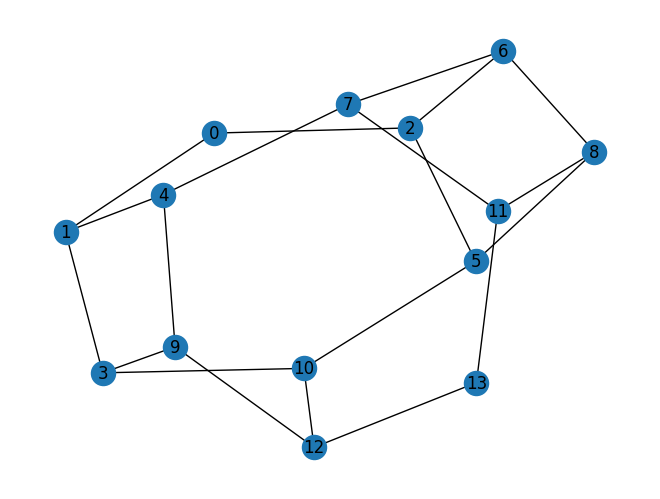

In [69]:
glued_tree_height = 2
N = 2 * (2 ** (glued_tree_height + 1) - 1)
print(f"Nodes in graph: {N}")

dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding=encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

T = 2
r = 4

num_time_points = 11
t_vals = np.linspace(0, T, num_time_points)

num_shots = 200
vertex = 0

use_error_mitigation = False

if use_error_mitigation:
    assert num_shots >= 500, "Number of shots should be at least 500"

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "r": r,
    "num_shots": num_shots,
    "vertex": vertex,
    "use_error_mitigation": use_error_mitigation,
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)
print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()
    
graph = get_glued_tree(glued_tree_height)

nx.draw(graph, with_labels=True)
A = nx.adjacency_matrix(graph, nodelist=sorted(graph.nodes()))

print("Two qubit gate count:", graph.size() * r * 2)

qpu_job_ids_filename = f'job_ids_qpu.json'

Gate count

In [70]:
# Construct the circuit
instructions = []

# Initial state preparation: start from root node
instructions.append(get_rx(np.pi, vertex))
instructions += get_qw_circuit(graph, T, r)
native_instructions, qubit_phase = get_native_circuit(n, instructions)


One qubit gates: 1
Two qubit gates: 160


Submit tasks

In [71]:
if use_real_machine:
    run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)
else:
    sim_freq = run_qw(N, dimension, n, encoding, bitstrings, num_time_points, graph, t_vals, TASK_DIR, vertex, r, num_shots, device, SAVE_DIR, use_real_machine, qpu_job_ids_filename)

Unitless time:  0.000
One qubit gates: 1
Two qubit gates: 0
Saving in experiment_data/glued_tree/597ce272d24248d19773c8239506ff24
Job id: cdb76027-ae66-49ad-8edc-6cc30eba77fc
Unitless time:  0.200
One qubit gates: 1
Two qubit gates: 160
Saving in experiment_data/glued_tree/597ce272d24248d19773c8239506ff24
Job id: 4114a50d-28b4-43c1-a1fc-749f4c75b279
Unitless time:  0.400
One qubit gates: 1
Two qubit gates: 160
Saving in experiment_data/glued_tree/597ce272d24248d19773c8239506ff24
Job id: 74c57de3-d721-48f9-9108-eba89f8968ad
Unitless time:  0.600
One qubit gates: 1
Two qubit gates: 160
Saving in experiment_data/glued_tree/597ce272d24248d19773c8239506ff24
Job id: ad20df45-7c1e-4093-a62f-a42858015210
Unitless time:  0.800
One qubit gates: 1
Two qubit gates: 160
Saving in experiment_data/glued_tree/597ce272d24248d19773c8239506ff24
Job id: d391685d-705b-4303-afd7-1986c9bfe702
Unitless time:  1.000
One qubit gates: 1
Two qubit gates: 160
Saving in experiment_data/glued_tree/597ce272d24248d197

Get data from completed tasks

In [26]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords, use_error_mitigation)

Getting job: 275caa0c-3d96-4958-9223-34a6164e9ba1
Job status: completed
Getting job: 67ad1bec-13ad-426a-be7c-945f4be58379
Job status: completed
Getting job: f2ec74d9-f9cf-44ea-a54d-8d3db63db30e
Job status: completed
Getting job: d3011c53-332f-4a75-b371-72aec5ab0543
Job status: completed
Getting job: 61c0a041-b56e-45b0-9a9c-f2cb7be6d4c7
Job status: completed
Getting job: 7e1dd468-0e6c-4ae0-abdd-d47667e3fd7d
Job status: completed
Getting job: 8aceb34b-e21a-4f1c-b3f8-5601b9fc294e
Job status: completed
Getting job: 19b1be02-7290-4e4e-805b-8de2326ffb63
Job status: completed
Getting job: d7f55b0d-d394-45e0-bcd5-06bf62aa57a3
Job status: completed
Getting job: 1da81c1d-376d-49b2-b1d4-3f8055cdf007
Job status: completed
Getting job: 7d923855-6868-40a8-8977-bc6ef8452271
Job status: completed
Getting job: 31194f6a-0ba2-4046-8bbc-9d4dedc133ce
Job status: completed
Getting job: 33777f01-55dd-43f6-8276-ed87eb997793
Job status: completed
Getting job: f02d1505-5000-4478-bc20-6f2a8fce0ff1
Job status: co

Post processing and figures

In [27]:
# ionq_freq_normalized = np.zeros_like(ionq_freq)
# for i in range(num_time_points):
#     if np.sum(ionq_freq[i]) > 0:
#         ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

# num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

In [55]:
# Ground truth
psi_0 = np.zeros(N)
psi_0[vertex] = 1

psi = expm_multiply(-1j * A, psi_0, start=0, stop=T, num=num_time_points)
ideal_dist = np.abs(psi) ** 2

def get_glued_tree_distance_vec(glued_tree_height):
    
    distance_vec = np.zeros(N)
    for i in range(2 ** (glued_tree_height + 1) - 1):
        distance_vec[i] = int(np.log2(i + 1))
    for i in np.arange(2 ** (glued_tree_height + 1) - 1, N):
        distance_vec[i] = 2 * (glued_tree_height + 1) - 1 - int(np.log2(N - i))

    return distance_vec


distance_vec = get_glued_tree_distance_vec(glued_tree_height)

# Compute propagation distance
propagation_distance_ideal = ideal_dist @ distance_vec
propagation_distance_sim = sim_freq @ distance_vec
propagation_distance_ionq = ionq_freq @ distance_vec

# Using unbiased sample variance to compute standard error
# propagation_distance_ionq_err = np.array(
#     [np.sqrt(ionq_freq_normalized[i] @ (distance_vec - propagation_distance_ionq[i]) ** 2 / (num_samples_subspace_ionq[i] - 1)) for i in range(num_time_points)]
# )


# valid_points_ionq = np.sum(ionq_freq, axis=1) > 0


In [56]:
# np.savez(join(SAVE_DIR, "data.npz"), 
#          ideal_dist=ideal_dist,
#          sim_freq_normalized=sim_freq_normalized,
#          ionq_freq_normalized=ionq_freq_normalized,
#          num_samples_subspace_ionq=num_samples_subspace_ionq)

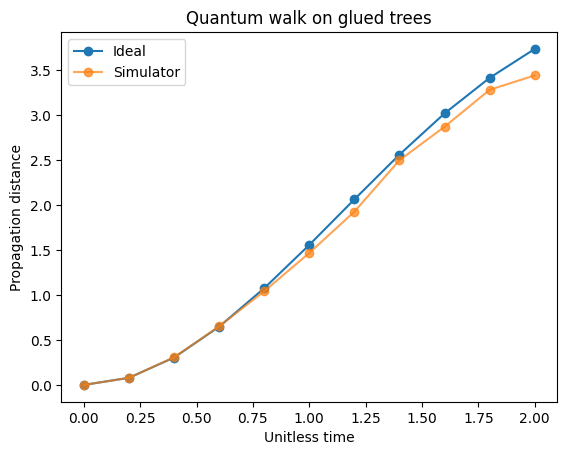

In [58]:
plt.plot(t_vals, propagation_distance_ideal, '-o', label="Ideal")
plt.plot(t_vals, propagation_distance_sim, '-o', label="Simulator", alpha=0.7)
# plt.errorbar(t_vals, propagation_distance_ionq, propagation_distance_ionq_err, fmt='-o', label="IonQ")
plt.xlabel("Unitless time")
plt.ylabel("Propagation distance")
plt.title("Quantum walk on glued trees")
plt.legend()
plt.show()

In [327]:
distance_mat = np.zeros((2 * (glued_tree_height + 1), N))
for i in range(N):
    distance_mat[int(distance_vec[i]), i] = 1

In [328]:
sim_freq_by_level = sim_freq @ distance_mat.T
ideal_dist_by_level = ideal_dist @ distance_mat.T

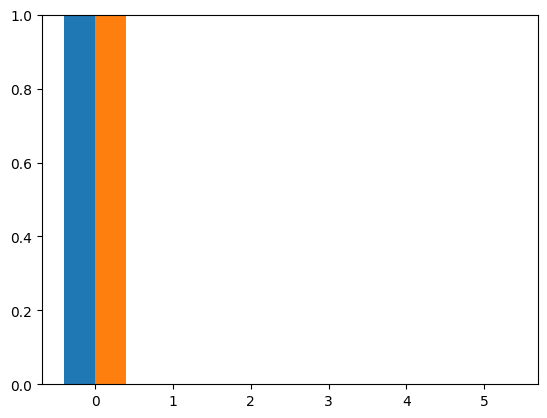

In [329]:
i = 0
plt.ylim(top=1)
plt.bar(np.arange(sim_freq_by_level.shape[1])-0.2, sim_freq_by_level[i], width=0.4)
plt.bar(np.arange(ideal_dist_by_level.shape[1]) + 0.2, ideal_dist_by_level[i], width=0.4)
plt.show()

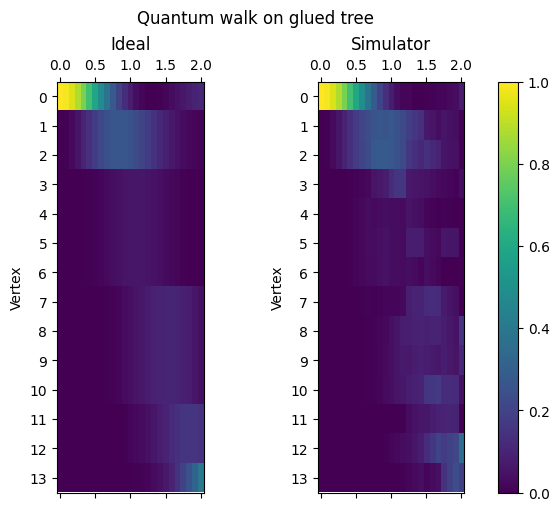

In [330]:

labels = ["Ideal", "Simulator"]#, "IonQ"]

fig, axs = plt.subplots(1, len(labels), constrained_layout=True, facecolor="white", figsize=(6,5))

max_prob = max(np.max(ideal_dist), np.max(sim_freq))#, np.max(ionq_freq))
im = axs[0].matshow(ideal_dist.T, vmin=0, vmax=max_prob)
axs[1].matshow(sim_freq.T, vmin=0, vmax=max_prob)
# axs[2].matshow(ionq_freq.T, vmin=0, vmax=max_prob)

aspect = 5

for i in range(len(labels)):
    axs[i].set_aspect(aspect)
    
    axs[i].set_ylabel("Vertex")
    axs[i].set_yticks(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_yticklabels(np.arange(ideal_dist.shape[1])[::1])
    axs[i].set_title(labels[i])

    axs[i].set_xticks(np.arange(ideal_dist.shape[0])[::6])
    axs[i].set_xticklabels([str(round(float(label), 3)) for label in t_vals[::6]])

fig.colorbar(im, ax=axs.ravel().tolist())
fig.suptitle("Quantum walk on glued tree")
plt.savefig(join("figures", f"glued_tree_heatmap_{n}_qubits.png"), facecolor="white", bbox_inches='tight')
plt.show()

# Spatial search

In [748]:
DATA_DIR = "experiment_data"
TASK_DIR = "spatial_search"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    # device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

    print(f"Using {device.name}")

experiment_data/spatial_search
Using StateVectorSimulator


In [749]:
N = 5
dimension = 2
encoding = "unary"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_2d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

lamb = 2
T = 6.0
r = 12

# lamb = 4 # N = 3
# T = 6.0 # N = 3 (awaiting results on machine)
# r = 18 # N = 3 (awaiting results on machine)

# lamb = 4 # N = 4
# r = 18 # N = 4

# lamb = 4 # N = 5
# r = 18 # N = 5

num_time_points = 8
t_vals = np.linspace(0, T, num_time_points)
num_shots = 500


use_native_gates = True
use_qiskit_transpiler = True
use_error_mitigation = True

if use_error_mitigation:
    assert num_shots >= 500, "Number of shots should be at least 500"

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "lamb": lamb,
    "r": r,
    "num_shots": num_shots,
    "use_native_gates": use_native_gates,
    "use_qiskit_transpiler": use_qiskit_transpiler,
    "use_error_mitigation": use_error_mitigation
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

name = "spatial_search"
qpu_job_ids_filename = f'job_ids_qpu.json'
sim_task_arns_filename = f'task_arns_simulator.json'

Save dir: experiment_data/spatial_search/6a9bde3e0b59386416060380e77b431e


In [750]:
# Compute the optimal gamma
L = get_laplacian_lattice(N, dimension)
marked_vertex_1 = np.zeros(N)
marked_vertex_1[0] = 1
marked_vertex_2 = np.zeros(N)
marked_vertex_2[N-1] = 1

marked_vertex = np.kron(marked_vertex_2, marked_vertex_1)
H_oracle = -csc_matrix(np.outer(marked_vertex, marked_vertex))
# Sign is flipped here; this function minimizes the difference between the two largest eigenvalues of gamma * L + H_oracle
gamma = scipy_get_optimal_gamma(L, -H_oracle, 0.3)
print(f"gamma = {gamma}")

gamma = 0.853563280105591


In [751]:
amplitudes_input = np.ones(N)
amplitudes_input /= np.linalg.norm(amplitudes_input)
circuit = state_prep_braket(N, dimension, amplitudes_input, encoding)
circuit.add_circuit(get_spatial_search_circuit(N, lamb, gamma, T, r, encoding))

instructions = get_circuit_from_braket(circuit)

if use_qiskit_transpiler:
    transpiled_circuit = transpile(get_qiskit_circuit(n * dimension, instructions),
                                basis_gates=["rx", "ry", "rz", "rxx", "ryy"],
                                optimization_level=3)
    instructions = get_circuit_from_qiskit(transpiled_circuit)

job = get_ionq_job_json("", N, dimension, num_shots, device, encoding, instructions, use_native_gates)

One qubit gates: 130
Two qubit gates: 162


Submit tasks

In [752]:
if use_real_machine:
    run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           gamma, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename,
           use_native_gates=use_native_gates, 
           use_qiskit_transpiler=use_qiskit_transpiler)
else:
    sim_freq = run_ss(N, dimension, encoding, bitstrings, num_time_points, t_vals, TASK_DIR, 
           gamma, lamb, r, num_shots, device, SAVE_DIR, use_real_machine, 
           qpu_job_ids_filename, sim_task_arns_filename)
    print(np.sum(sim_freq, axis=1))

Unitless time:  0.000
Unitless time:  0.857
Unitless time:  1.714
Unitless time:  2.571
Unitless time:  3.429
Unitless time:  4.286
Unitless time:  5.143
Unitless time:  6.000
[1.         0.91486232 0.85562974 0.84389992 0.90107864 0.98147652
 0.99063865 0.93943168]


Get data from completed tasks

In [769]:
ionq_freq = get_results(join(SAVE_DIR, qpu_job_ids_filename), num_time_points, codewords, use_error_mitigation=False)
print(np.sum(ionq_freq, axis=1))

Getting job: d8f5ab5c-50bb-42f9-b92a-7a694845038b
Job status: completed
Getting job: e0bd762a-a6ff-4cc5-8d44-99359c2d6092
Job status: completed
Getting job: 8a7e451e-ec2a-4470-8850-defe6d3c80f9
Job status: completed
Getting job: 6b117bc8-0738-47c2-8dd0-7770a4d8da05
Job status: completed
Getting job: b8d1a97d-c24d-4375-bbe2-08dac32ef46d
Job status: completed
Getting job: 66688a53-2072-47fb-a58d-de6bedfb95cc
Job status: completed
Getting job: 9b39c292-923c-44b1-a56f-64b85c0958b9
Job status: completed
Getting job: f24e6548-5d9d-4071-91cf-52793b662672
Job status: completed
[0.906 0.772 0.744 0.646 0.482 0.598 0.496 0.358]


Post processing and figures

In [770]:
# Ideal
psi_0 = np.ones(N ** dimension, dtype=np.complex64)
psi_0 /= np.linalg.norm(psi_0)

H = -gamma * L + H_oracle
num_time_points_ideal = 128
psi = expm_multiply(-1j * H, psi_0, start=0, stop=T, num=num_time_points_ideal)
ideal_dist = np.abs(psi) ** 2
ideal_success_probability = ideal_dist[:, N ** dimension - N]

In [771]:
sim_freq_normalized = np.zeros_like(sim_freq)
for i in range(num_time_points):
    if np.sum(sim_freq[i]) > 0:
        sim_freq_normalized[i] = sim_freq[i] / np.sum(sim_freq[i])

ionq_freq_normalized = np.zeros_like(ionq_freq)
for i in range(num_time_points):
    if np.sum(ionq_freq[i]) > 0:
        ionq_freq_normalized[i] = ionq_freq[i] / np.sum(ionq_freq[i])

num_samples_subspace_ionq = np.sum(ionq_freq, axis=1) * num_shots

valid_points_sim = np.sum(sim_freq, axis=1) > 0
valid_points_ionq = num_samples_subspace_ionq > 0

success_prob_sim = sim_freq_normalized[:,-N]
success_prob_ionq = ionq_freq_normalized[:,-N]
err_ionq = np.sqrt(success_prob_ionq * (1 - success_prob_ionq) / (num_samples_subspace_ionq - 1))

In [773]:
np.savez(join(SAVE_DIR, "data.npz"), 
         ideal_dist=ideal_dist,
         sim_freq_normalized=sim_freq_normalized,
         ionq_freq_normalized=ionq_freq_normalized,
         num_samples_subspace_ionq=num_samples_subspace_ionq)

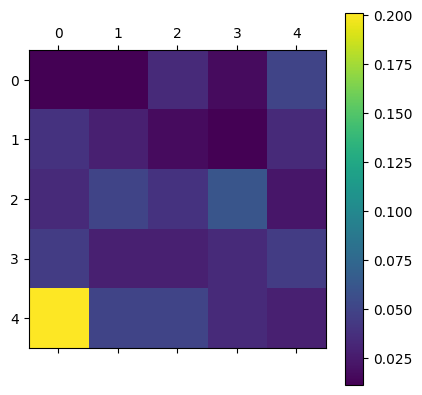

In [774]:
plt.matshow(ionq_freq_normalized[-1].reshape((N,N)))
plt.colorbar()
plt.show()

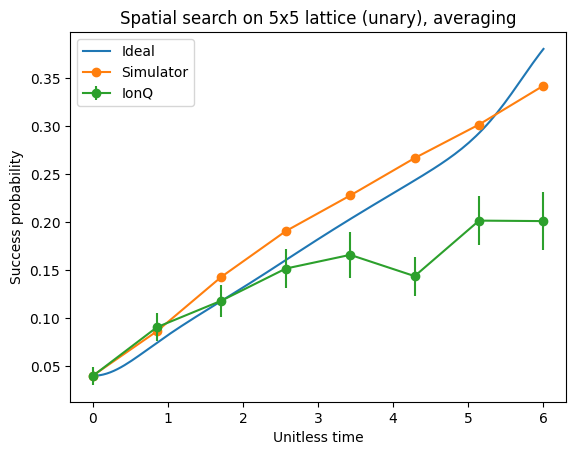

In [775]:

plt.title(f"Spatial search on {N}x{N} lattice ({encoding}), averaging")
plt.plot(np.linspace(0, T, num_time_points_ideal), ideal_success_probability, label="Ideal")
plt.plot(t_vals, success_prob_sim, '-o', label="Simulator")
plt.errorbar(t_vals[valid_points_ionq], success_prob_ionq[valid_points_ionq], err_ionq, fmt='-o', label="IonQ")
plt.ylabel("Success probability")
plt.xlabel("Unitless time")
plt.legend()
plt.show()

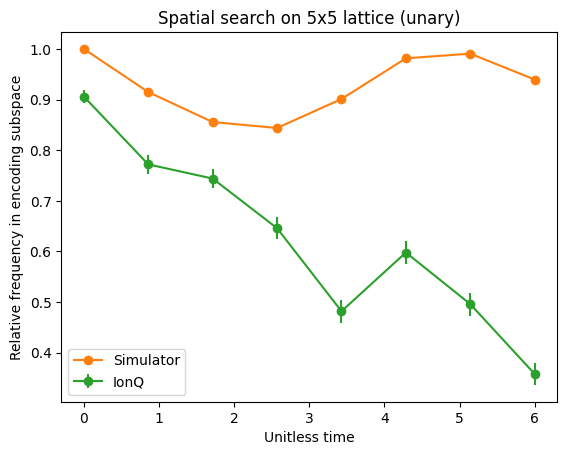

In [776]:
plt.plot(t_vals, np.sum(sim_freq, axis=1), '-o', label="Simulator", color="#ff7f0e")
plt.errorbar(t_vals, np.sum(ionq_freq, axis=1), np.sqrt(np.sum(ionq_freq, axis=1) * (1 - np.sum(ionq_freq, axis=1)) / (num_shots - 1)), fmt='-o', label="IonQ", color="#2ca02c")
plt.xlabel("Unitless time")
plt.ylabel("Relative frequency in encoding subspace")
plt.title(f"Spatial search on {N}x{N} lattice ({encoding})")
plt.legend()
plt.show()

# Fock space method for real space dynamics

In [739]:
DATA_DIR = "experiment_data"
TASK_DIR = "fock_space_method"

CURR_DIR = DATA_DIR
check_and_make_dir(CURR_DIR)
CURR_DIR = join(CURR_DIR, TASK_DIR)
check_and_make_dir(CURR_DIR)

print(CURR_DIR)

use_real_machine = False
if use_real_machine:
    device = "qpu.aria-1"
    print("Device:", device)
else:
    device = LocalSimulator()

    print(f"Using {device.name}")

experiment_data/fock_space_method
Using StateVectorSimulator


In [740]:
N = 5
dimension = 1
encoding = "one-hot"
n = num_qubits_per_dim(N, encoding)
codewords = get_codewords_1d(n, encoding, periodic=False)
bitstrings = get_bitstrings(N, dimension, encoding)

T = 5
r = 18
a = 1
b = -1/2

num_time_points = 21
t_vals = np.linspace(0, T, num_time_points)
num_shots = 4000

use_error_mitigation = True

experiment_info = {
    "N": N,
    "dimension": dimension,
    "encoding": encoding,
    "T": T,
    "num_time_points": num_time_points,
    "r": r,
    "a": a,
    "b": b,
    "num_shots": num_shots,
    "use_error_mitigation": use_error_mitigation
}

hash_str = hashlib.md5(json.dumps(experiment_info).encode("utf-8")).hexdigest()
SAVE_DIR = join(CURR_DIR, hash_str)
check_and_make_dir(SAVE_DIR)

print("Save dir:", SAVE_DIR)

with open(join(SAVE_DIR, "experiment_info.json"), "w") as f:
    json.dump(experiment_info, f)
    f.close()

for i in range(num_time_points):
    if not exists(join(SAVE_DIR, f"t_{i}")):
        mkdir(join(SAVE_DIR, f"t_{i}"))

qpu_job_ids_filename_z = 'job_ids_qpu_z.json'
qpu_job_ids_filename_x = 'job_ids_qpu_x.json'

Save dir: experiment_data/fock_space_method/69ad1269c7c9270dd6dc3589f9169a25


Check gate count

In [737]:
instructions = []
# Initial state preparation: start from root node
instructions.append(get_rx(np.pi, 0))
instructions += get_fock_space_method_circuit(N, a, b, T, r, encoding)

job = get_ionq_job_json("test", N, dimension, num_shots, device, encoding, instructions)


One qubit gates: 1
Two qubit gates: 144


Submit tasks

In [738]:
if use_real_machine:
    run_fock_space_method(N, dimension, encoding, num_time_points, t_vals, 
                          TASK_DIR, r, a, b, num_shots, device, SAVE_DIR, 
                          use_real_machine, qpu_job_ids_filename_z, qpu_job_ids_filename_x)
else:
    sim_prob_z, sim_prob_x = run_fock_space_method(N, dimension, encoding, num_time_points, t_vals, 
                                                   TASK_DIR, r, a, b, num_shots, device, SAVE_DIR, 
                                                   use_real_machine, qpu_job_ids_filename_z, qpu_job_ids_filename_x)

Unitless time:  0.000
One qubit gates: 1
Two qubit gates: 0
Job id: 295d94d2-3177-4431-8dc5-fc8147307142
One qubit gates: 6
Two qubit gates: 0
Job id: 457c3d96-bb4f-4fbb-9e42-06134962ba02
Saving IonQ job ids
Unitless time:  0.250
One qubit gates: 1
Two qubit gates: 144
Job id: 3f121435-4959-422d-8c0e-2bac5f58ae8e
One qubit gates: 6
Two qubit gates: 144
Job id: 746ad3d8-3ed2-45f6-abb8-b96411f1ca81
Saving IonQ job ids
Unitless time:  0.500
One qubit gates: 1
Two qubit gates: 144
Job id: ea244e67-fb50-43c8-b2de-4f3224858b12
One qubit gates: 6
Two qubit gates: 144
Job id: f6b2b1e8-83b5-4691-944f-ccd324c21e19
Saving IonQ job ids
Unitless time:  0.750
One qubit gates: 1
Two qubit gates: 144
Job id: 51370aeb-974c-4640-9e20-5f0d6b31c9c0
One qubit gates: 6
Two qubit gates: 144
Job id: ce3f0454-5ec7-464d-a97a-40aa1b8d8119
Saving IonQ job ids
Unitless time:  1.000
One qubit gates: 1
Two qubit gates: 144
Job id: 5032e4d6-095e-445a-9985-88ca0d05f218
One qubit gates: 6
Two qubit gates: 144
Job id: 2

Get data from completed tasks

In [715]:
def get_results_fock_space_method(N, job_ids_path, use_error_mitigation=False):
    with open(job_ids_path, "r") as f:
        job_ids = json.load(f)
        f.close()

    freq = np.zeros(2 ** N)
    for job_id in job_ids:

        freq += get_ionq_single_job_result(job_id, range(2 ** N), use_error_mitigation)

    # Take the average
    freq /= len(job_ids)

    return freq

In [716]:
ionq_freq_z = []
for i in range(num_time_points):
    ionq_freq_z.append(get_results_fock_space_method(N, join(SAVE_DIR, f"t_{i}", qpu_job_ids_filename_z)))

ionq_freq_x = []
for i in range(num_time_points):
    ionq_freq_x.append(get_results_fock_space_method(N, join(SAVE_DIR, f"t_{i}", qpu_job_ids_filename_x)))

FileNotFoundError: [Errno 2] No such file or directory: 'experiment_data/fock_space_method/5fd75fe770bc6545fc5533010b7eeab4/t_0/job_ids_qpu_z.json'

Post processing and figures

In [717]:
# Observable for each computational basis state
x_obs_vec = np.zeros(2 ** N)
p2_obs_vec_x = np.zeros(2 ** N)
p2_obs_vec_z = np.zeros(2 ** N)

for i in range(2 ** N):
    bitstring = np.binary_repr(i, N)[::-1]

    for j in range(N-1):
        if bitstring[j] == bitstring[j+1]:
            x_obs_vec[i] += np.sqrt((j+1))
        else:
            x_obs_vec[i] -= np.sqrt((j+1))
        
    for j in range(N-2):
        if bitstring[j] == bitstring[j+2]:
            p2_obs_vec_x[i] += np.sqrt((j+1) * (j+2))
        else:
            p2_obs_vec_x[i] -= np.sqrt((j+1) * (j+2))
    
    for j in range(N):
        if bitstring[j] == '1':
            p2_obs_vec_z[i] += (j + 1/2)


x_obs_vec /= np.sqrt(2)
p2_obs_vec_x *= (-0.5)



In [718]:
x_obs_sim = np.zeros(num_time_points)
p2_obs_sim = np.zeros(num_time_points)

# x_obs_ionq = np.zeros(num_time_points)
# p2_obs_x_ionq = np.zeros(num_time_points)
# p2_obs_z_ionq = np.zeros(num_time_points)
# pos_observable_ionq = []
for i in range(num_time_points):
    x_obs_sim[i] = x_obs_vec @ sim_prob_x[i]
    # x_obs_ionq[i] = x_obs_vec @ ionq_freq_x[i]

    p2_obs_sim[i] = p2_obs_vec_x @ sim_prob_x[i] + (p2_obs_vec_z[codewords] @ sim_prob_z[i][codewords]) / np.sum(sim_prob_z[i][codewords])
    # p2_obs_x_ionq[i] = p2_obs_vec_x @ ionq_freq_x[i]
    # p2_obs_z_ionq[i] = (p2_obs_vec_z[codewords] @ ionq_freq_z[i][codewords]) / np.sum(ionq_freq_z[i][codewords])

# p2_obs_ionq = p2_obs_x_ionq + p2_iobs_z_ionq

In [663]:
x_obs_ionq_err = np.zeros(num_time_points)
kinetic_energy_err = np.zeros(num_time_points)

for i in range(num_time_points):
    x_obs_ionq_err[i] = np.sqrt(ionq_freq_x[i] @ (x_obs_vec - x_obs_ionq[i]) ** 2 / (M * num_shots - 1))

    # Sqrt of variance of mean for XX observables plus Z observables
    kinetic_energy_err[i] = np.sqrt(ionq_freq_x[i] @ 0.5 * (p2_obs_vec_x - p2_obs_x_ionq[i]) ** 2 / (M * num_shots - 1) + \
                                    ionq_freq_z[i][codewords] @ 0.5 * (p2_obs_vec_z[codewords] - p2_obs_z_ionq[i]) ** 2 / (M * num_shots - 1))


NameError: name 'ionq_freq_x' is not defined

In [719]:
def get_real_space_hamiltonian(N, a, b):
    p_sq = sum_h_z(N, [-0.5 * (j+1/2) for j in range(N)])
    J = np.zeros((N,N))
    for i in range(N-2):
        J[i, i+2] = -0.5 * np.sqrt((i+1)*(i+2))
    p_sq += (sum_J_xx(N, J) + sum_J_yy(N, J)) / 2

    J = np.zeros((N,N))
    for i in range(N-1):
        J[i, i+1] = np.sqrt((i+1))
    f_linear = b * (1/np.sqrt(2)) * (sum_J_xx(N, J) + sum_J_yy(N, J)) / 2

    J = np.zeros((N,N))
    for i in range(N-2):
        J[i, i+2] = 0.5 * np.sqrt((i+1)*(i+2))

    f_quadratic = 0.5 * a * (sum_h_z(N, [-0.5 * (j+1/2) for j in range(N)]) + (sum_J_xx(N, J) + sum_J_yy(N, J)) / 2)

    H = 0.5 * p_sq + f_linear + f_quadratic
    return H

In [720]:
H_simulator = get_real_space_hamiltonian(N, a, b)
codewords = get_codewords_1d(n, encoding=encoding, periodic=False)

In [721]:
psi_0 = np.zeros(2 ** N)
psi_0[codewords[0]] = 1

# Position observable
J = np.zeros((N,N))
for i in range(N-1):
    J[i, i+1] = np.sqrt((i+1))
x_hat = (1/np.sqrt(2)) * sum_J_xx(N, J)

p_sq = sum_delta_n(N, [(j+1/2) for j in range(N)])
J = np.zeros((N,N))
for i in range(N-2):
    J[i, i+2] = -0.5 * np.sqrt((i+1)*(i+2))
p_sq += sum_J_xx(N, J)

num_time_points_ideal = num_time_points
psi = expm_multiply(-1j * H_simulator, psi_0, start=0, stop=T, num=num_time_points_ideal)

In [722]:
x_obs_ham_ebd = np.zeros(num_time_points_ideal)
p2_obs_ham_ebd = np.zeros(num_time_points_ideal)

for i in range(num_time_points_ideal):
    x_obs_ham_ebd[i] = (np.conj(psi[i]) @ x_hat @ psi[i]).real
    p2_obs_ham_ebd[i] = (np.conj(psi[i]) @ p_sq @ psi[i]).real

In [723]:
# Analytical solution
expected_position_analytical = (b / a) * (np.cos(np.sqrt(a) * np.linspace(0, T, num_time_points_ideal)) - 1)

In [580]:
# data = np.load(join(SAVE_DIR, "data.npz"))
# expected_position_analytical = data["expected_position_analytical"]
# ionq_freq_z = data["ionq_freq_z"]           # Relative frequency in z basis (all 2^5 states; 3000 shots total for each time point)
# ionq_freq_x = data["ionq_freq_x"]           # Relative frequency in x basis (all 2^5 states; 3000 shots total for each time point)
# x_obs_ham_ebd = data["x_obs_ham_ebd"]       # <\hat{x}> for Hamiltonian embedding
# x_obs_sim = data["x_obs_sim"]               # <\hat{x}> for circuit simulator
# x_obs_ionq = data["x_obs_ionq"]             # <\hat{x}> for IonQ
# x_obs_ionq_err = data["x_obs_ionq_err"]     # Standard error for <\hat{x}>; refer to notebook for calculation
# p2_obs_ham_ebd = data["p2_obs_ham_ebd"]     # <\hat{p}^2> for Hamiltonian embedding
# p2_obs_sim = data["p2_obs_sim"]             # <\hat{p}^2> for circuit simulator
# p2_obs_ionq = data["p2_obs_ionq"]

In [581]:
# np.savez(join(SAVE_DIR, "data.npz"), 
#          expected_position_analytical=expected_position_analytical,
#          ionq_freq_z=ionq_freq_z,           # Relative frequency in z basis (all 2^5 states; 3000 shots total for each time point)
#          ionq_freq_x=ionq_freq_x,           # Relative frequency in x basis (all 2^5 states; 3000 shots total for each time point)
#          x_obs_ham_ebd=x_obs_ham_ebd,       # <\hat{x}> for Hamiltonian embedding
#          x_obs_sim=x_obs_sim,               # <\hat{x}> for circuit simulator
#          x_obs_ionq=x_obs_ionq,             # <\hat{x}> for IonQ
#          x_obs_ionq_err=x_obs_ionq_err,     # Standard error for <\hat{x}>; refer to notebook for calculation
#          p2_obs_ham_ebd=p2_obs_ham_ebd,     # <\hat{p}^2> for Hamiltonian embedding
#          p2_obs_sim=p2_obs_sim,             # <\hat{p}^2> for circuit simulator
#          p2_obs_ionq=p2_obs_ionq)           # <\hat{p}^2> for IonQ

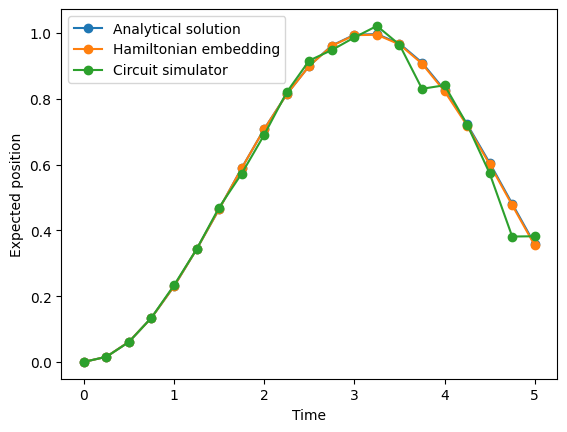

In [724]:

plt.plot(np.linspace(0, T, num_time_points_ideal), expected_position_analytical, '-o', label="Analytical solution")
plt.plot(np.linspace(0, T, num_time_points_ideal), x_obs_ham_ebd, '-o', label="Hamiltonian embedding")
plt.plot(t_vals, x_obs_sim, '-o', label="Circuit simulator")
# plt.errorbar(t_vals, x_obs_ionq, x_obs_ionq_err, fmt='-o', label="IonQ")
plt.ylabel("Expected position")
plt.xlabel("Time")
plt.legend()
plt.show()

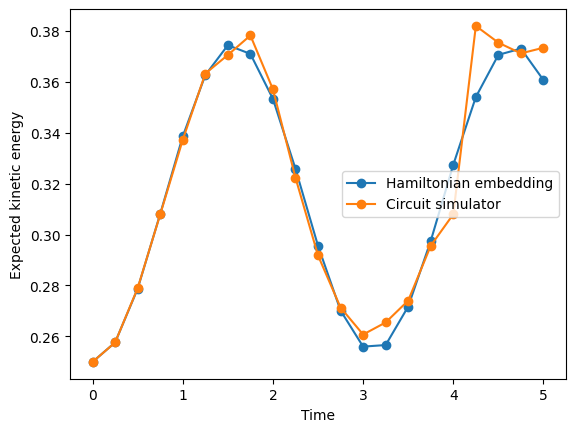

In [725]:
plt.plot(np.linspace(0, T, num_time_points_ideal), 0.5 * p2_obs_ham_ebd, '-o', label="Hamiltonian embedding")
plt.plot(t_vals, 0.5 * p2_obs_sim, '-o', label="Circuit simulator")
# plt.errorbar(t_vals, 0.5 * p2_obs_ionq, kinetic_energy_err, fmt='-o', label="IonQ")
plt.ylabel("Expected kinetic energy")
plt.xlabel("Time")
plt.legend()
plt.show()